In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_regression
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    print("Load Data")
data_df.head()

RANDOM_STATE = 42

In [18]:
# Define X and Y
data_df["Sex_binary"] = data_df["Sex"].map({"M": 0, "m": 0, "F": 1, "f": 1})
ad_hc_df = data_df[
    data_df["Diagnosis"].isin(["AD", "HC"]) & (data_df["Harmonized"].notna())
].copy()
tbi_df = data_df[
    data_df["Diagnosis"].isin(["NEG", "POS"]) & (data_df["Harmonized"].notna())
].copy()

X_ad_hc_evc = StandardScaler().fit_transform(np.vstack(ad_hc_df["EVC"].values))
age_ad_hc = ad_hc_df["Age"].values.reshape(-1, 1)
sex_ad_hc = ad_hc_df["Sex_binary"].values.reshape(-1, 1)

X_ad_hc = np.hstack([X_ad_hc_evc, age_ad_hc, sex_ad_hc])
y_ad_hc = ad_hc_df["Diagnosis"].map({"AD": 1, "HC": 0}).values

X_tbi_evc = StandardScaler().fit_transform(np.vstack(tbi_df["EVC"].values))
age_tbi = tbi_df["Age"].values.reshape(-1, 1)
sex_tbi = tbi_df["Sex_binary"].values.reshape(-1, 1)

X_tbi = np.hstack([X_tbi_evc, age_tbi, sex_tbi])
y_tbi = tbi_df["Diagnosis"].map({"POS": 1, "NEG": 0}).values

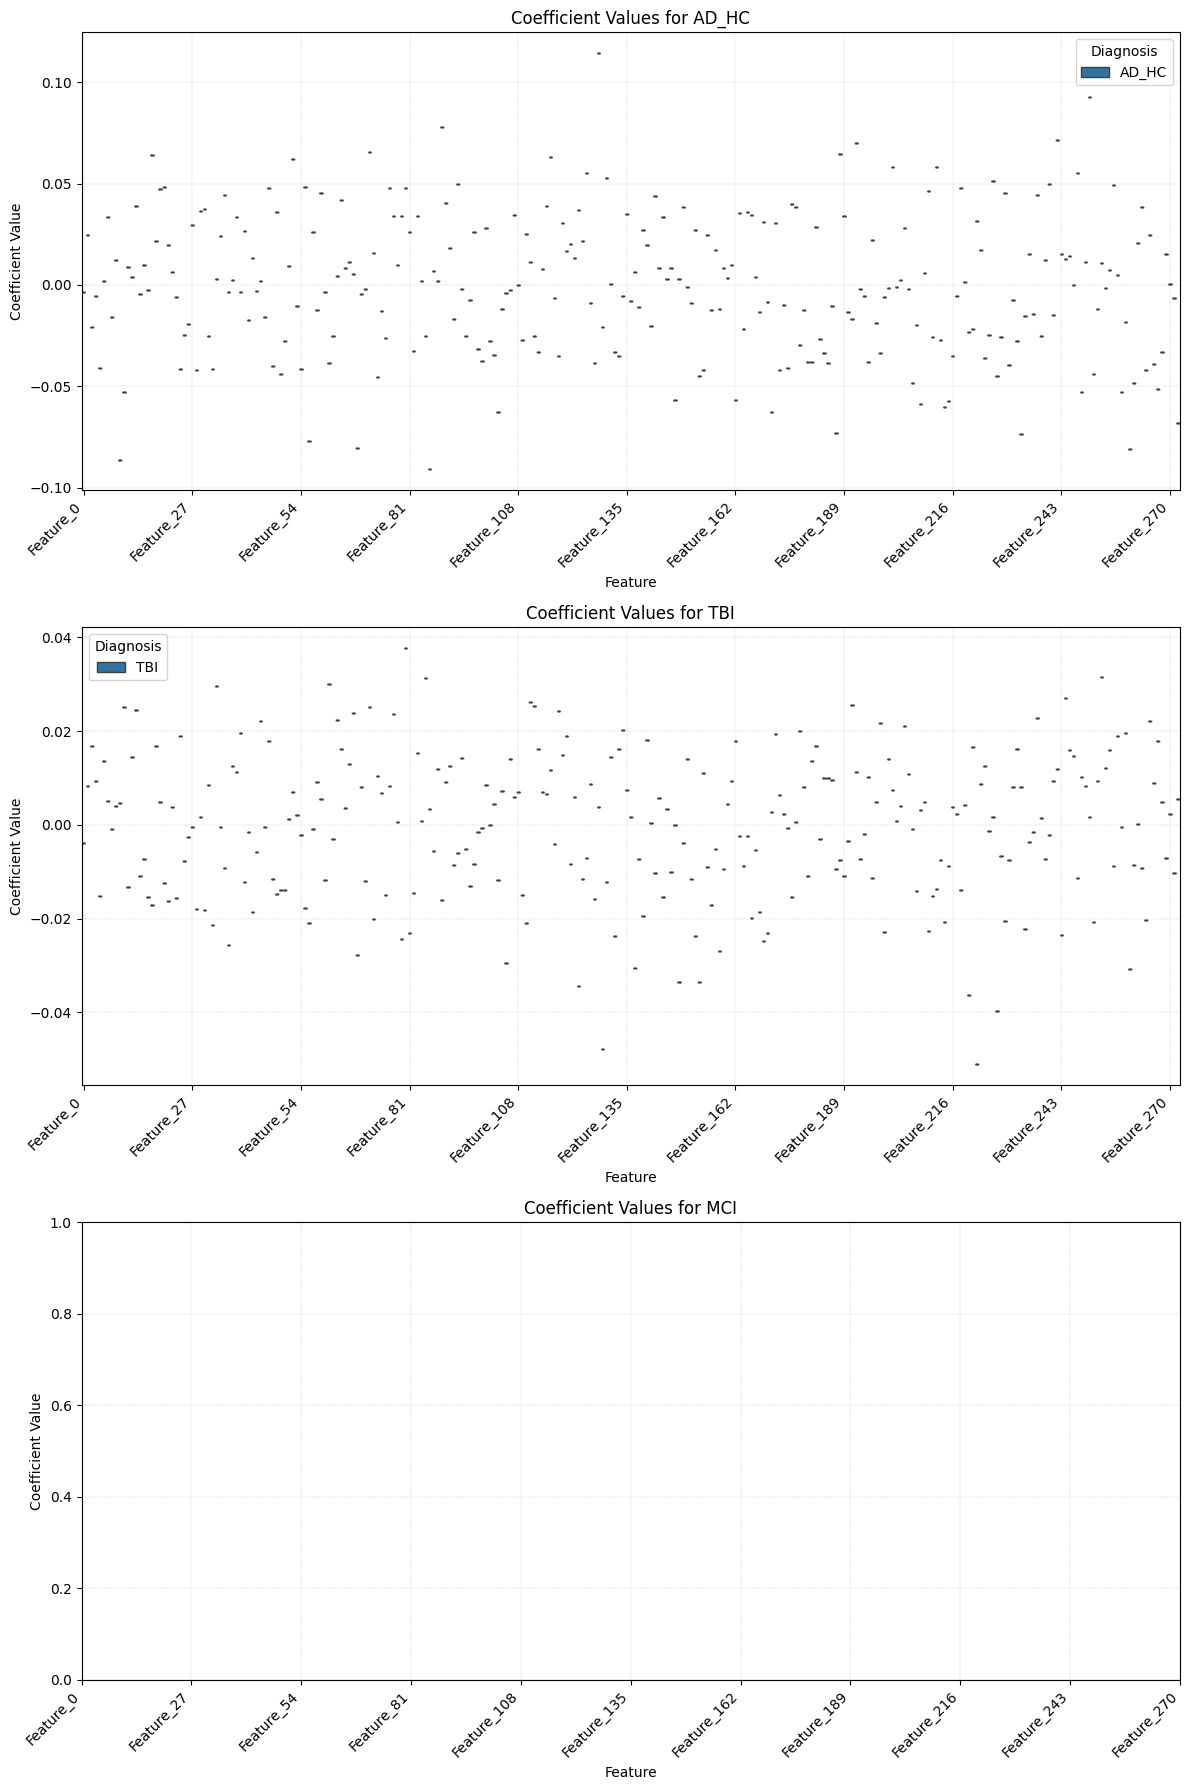

In [19]:
def run_ridge_cv(X, y):
    model = RidgeCV(alphas=[0.1, 1.0, 10.0]) 
    model.fit(X, y)
    return model.coef_

coef_ad_hc = run_ridge_cv(X_ad_hc, y_ad_hc)
coef_tbi = run_ridge_cv(X_tbi, y_tbi)
# coef_mci = run_ridge_cv(X_mci, y_mci)

coef_df = pd.DataFrame({
    "Feature": [f"Feature_{i}" for i in range(X_ad_hc.shape[1])],
    "AD_HC": coef_ad_hc,
    "TBI": coef_tbi,
    # "MCI": coef_mci
})

coef_df_melted = coef_df.melt(id_vars=["Feature"], var_name="Diagnosis", value_name="Coefficient")

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

def set_xticks(ax, num_ticks, total_ticks):
    step_size = total_ticks // num_ticks
    ticks_to_show = list(range(0, total_ticks, step_size))
    ax.set_xticks(ticks_to_show)
    ax.set_xticklabels([f"Feature_{i}" for i in ticks_to_show], rotation=45, ha='right')

sns.boxplot(x="Feature", y="Coefficient", hue="Diagnosis", data=coef_df_melted[coef_df_melted['Diagnosis'] == 'AD_HC'], ax=axes[0], showfliers=False)
axes[0].set_title("Coefficient Values for AD_HC")
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Coefficient Value")
set_xticks(axes[0], 10, len(coef_df))  
axes[0].grid(True, which='major', axis='both', linestyle='--', linewidth=0.2)

sns.boxplot(x="Feature", y="Coefficient", hue="Diagnosis", data=coef_df_melted[coef_df_melted['Diagnosis'] == 'TBI'], ax=axes[1], showfliers=False)
axes[1].set_title("Coefficient Values for TBI")
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Coefficient Value")
set_xticks(axes[1], 10, len(coef_df))  
axes[1].grid(True, which='major', axis='both', linestyle='--', linewidth=0.2)

sns.boxplot(x="Feature", y="Coefficient", hue="Diagnosis", data=coef_df_melted[coef_df_melted['Diagnosis'] == 'MCI'], ax=axes[2], showfliers=False)
axes[2].set_title("Coefficient Values for MCI")
axes[2].set_xlabel("Feature")
axes[2].set_ylabel("Coefficient Value")
set_xticks(axes[2], 10, len(coef_df))  
axes[2].grid(True, which='major', axis='both', linestyle='--', linewidth=0.2)

plt.tight_layout()
plt.show()

227	0.07933847587755813
80	0.07546438717209714
153	0.06714933526151376
260	0.06127997354138556
68	0.05565586613478052
71	0.050364167600459586
13	0.048959653035286016
132	0.04745471264414308
77	0.04725975139457528
220	0.04663966531617894



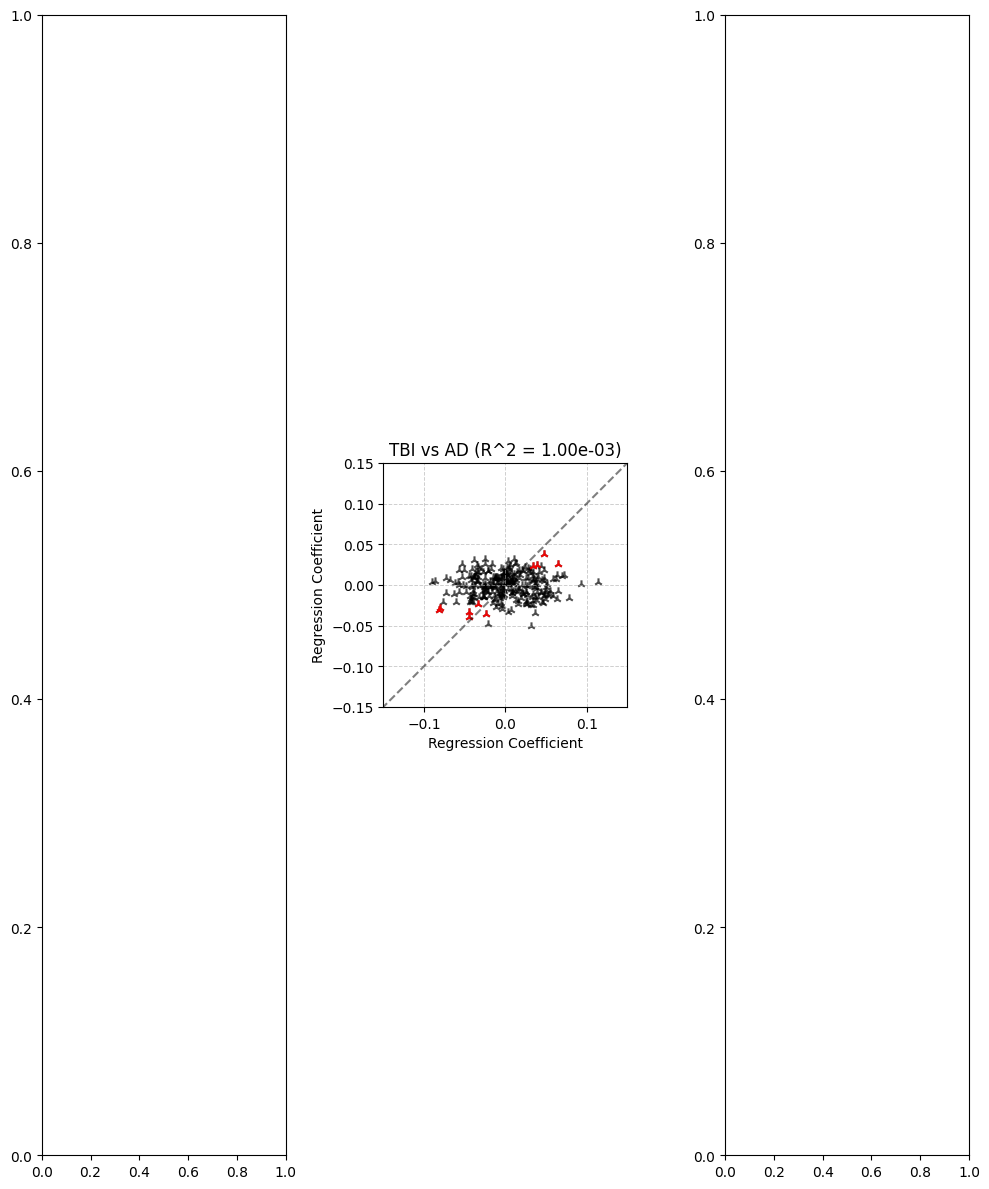

In [20]:
def highlightInformative(x, y, axis):
    residuals = np.abs(y - x)
    magnitudes = np.abs(x) + np.abs(y)
    weights = -1 * residuals + magnitudes
    top_10_indices = np.argsort(weights)[-10:][::-1]
    axis.scatter(x[top_10_indices], y[top_10_indices], alpha=0.9, c="red", marker="2")
    for idx in top_10_indices:
        print(f"{idx}\t{weights[idx]}")
    print("==========\n")

def calculate_r2(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    return r2_score(y, y_pred)

fig, axes = plt.subplots(1, 3, figsize=(10, 12))

# r2_tbi_mci = calculate_r2(coef_mci, coef_tbi)
# axes[0].scatter(coef_mci, coef_tbi, alpha=0.7, c="black", marker="2")
# axes[0].plot([-1, 1], [-1, 1], linestyle="--", color="black", alpha=0.5)
# axes[0].set_xlabel("Regression Coefficient")
# axes[0].set_ylabel("Regression Coefficient")
# axes[0].set_title(f"TBI vs MCI (R^2 = {r2_tbi_mci:.2e})")
# axes[0].grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
# axes[0].set_xlim([-0.15, 0.15])
# axes[0].set_ylim([-0.15, 0.15])
# axes[0].set_aspect("equal", adjustable="box")
# highlightInformative(coef_mci, coef_tbi, axes[0])

r2_ad_hc_tbi = calculate_r2(coef_ad_hc, coef_tbi)
axes[1].scatter(coef_ad_hc, coef_tbi, alpha=0.7, c="black", marker="2")
axes[1].plot([-1, 1], [-1, 1], linestyle="--", color="black", alpha=0.5)
axes[1].set_xlabel("Regression Coefficient")
axes[1].set_ylabel("Regression Coefficient")
axes[1].set_title(f"TBI vs AD (R^2 = {r2_ad_hc_tbi:.2e})")
axes[1].grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
axes[1].set_xlim([-0.15, 0.15])
axes[1].set_ylim([-0.15, 0.15])
axes[1].set_aspect("equal", adjustable="box")
highlightInformative(coef_ad_hc, coef_tbi, axes[1])

# r2_ad_hc_mci = calculate_r2(coef_ad_hc, coef_mci)
# axes[2].scatter(coef_ad_hc, coef_mci, alpha=0.7, c="black", marker="2")
# axes[2].plot([-1, 1], [-1, 1], linestyle="--", color="black", alpha=0.5)
# axes[2].set_xlabel("Regression Coefficient")
# axes[2].set_ylabel("Regression Coefficient")
# axes[2].set_title(f"MCI vs AD (R^2 = {r2_ad_hc_mci:.2e})")
# axes[2].grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
# axes[2].set_xlim([-0.15, 0.15])
# axes[2].set_ylim([-0.15, 0.15])
# axes[2].set_aspect("equal", adjustable="box")
# highlightInformative(coef_ad_hc, coef_mci, axes[2])

plt.tight_layout()
plt.show()

In [2]:
df = pd.DataFrame(data_df)
df = df.drop(columns=["Data", "Connectome", "Harmonized", "CLU", "DIV"])
expanded_columns = []

for idx, row in df.iterrows():
    evc_matrix = row['EVC']
    
    if evc_matrix is not None:
        expanded_columns.append(evc_matrix.flatten())
    else:
        expanded_columns.append([np.nan] * 4) 

evc_expanded = pd.DataFrame(expanded_columns, index=df.index)

evc_expanded.columns = [f'EVC_{i}' for i in range(evc_expanded.shape[1])]

df = pd.concat([df.drop(columns=['EVC']), evc_expanded], axis=1)

df.to_csv('expanded_dataframe.csv', index=False)

In [25]:
f_stat_ad, p_values_ad = f_regression(X_ad_hc, y_ad_hc)
f_stat_tbi, p_values_tbi = f_regression(X_tbi, y_tbi)

_, p_values_ad_hc_corrected, _, _ = multipletests(p_values_ad, method="bonferroni")
_, p_values_tbi_corrected, _, _ = multipletests(p_values_tbi, method="bonferroni")

significant_ad_hc = np.where(p_values_ad_hc_corrected < 0.05)[0]
significant_tbi = np.where(p_values_tbi_corrected < 0.05)[0]

print(f"P Values AD/HC: {p_values_ad}", end="\n========\n\n")
print(f"P Values TBI+/TBI-: {p_values_tbi}", end="\n========\n\n")

P Values AD/HC: [4.17286447e-01 9.81237580e-01 7.76652739e-01 4.37737515e-01
 5.66112872e-03 5.34218832e-01 2.67867889e-01 9.69224695e-01
 3.25782487e-01 4.98662294e-01 1.64522430e-01 3.83998838e-01
 3.39104657e-01 9.23403897e-01 2.95231546e-01 1.73653088e-01
 2.67186111e-01 2.34193283e-01 5.86222388e-03 7.39263802e-03
 9.75224860e-02 3.22223863e-01 6.75251523e-01 6.73303845e-01
 5.43894246e-01 4.02348625e-01 9.34381764e-01 7.24061411e-02
 3.18542227e-01 2.20102465e-01 3.92311795e-02 5.35046553e-01
 8.54490901e-01 4.74343657e-01 5.27227812e-01 2.84691119e-01
 5.96197984e-01 2.24682243e-01 5.20082892e-01 9.15486291e-02
 1.58785765e-01 7.97618545e-01 4.82165327e-02 8.30830685e-01
 3.52296425e-01 8.86923216e-01 1.37578472e-01 8.07975840e-02
 3.31064796e-01 6.79204360e-02 1.86405139e-01 4.43411808e-02
 9.43825121e-02 5.64436361e-02 9.32531409e-01 9.76375757e-01
 5.50936808e-03 1.51178956e-01 3.95018619e-01 6.39307208e-01
 4.57730216e-01 8.03870626e-01 5.60651018e-01 8.37889845e-01
 6.76918

In [23]:
significant_ad_hc

array([], dtype=int64)